In [12]:
import os
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

from models.GAN2 import GAN


source_path = './images/miro/mono/'
X_data = []


for count, filename in enumerate(os.listdir(source_path)):
    f = os.path.join(source_path, filename)
    image = Image.open(f).convert('L').resize((28, 28))
    # print(f"shape: {np.array(image).shape}")
    X_data.append(np.array(image))

X_data = np.array(X_data)
X_data = X_data.reshape(X_data.shape[0], 28, 28, 1)
print('X_data shape:', X_data.shape)

X_data shape: (937, 28, 28, 1)


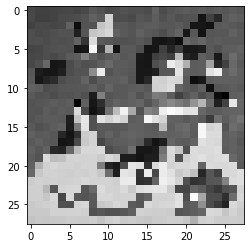

In [2]:
plt.imshow(X_data[150,:,:,0], cmap = 'gray')

In [3]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'miro'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [4]:
filters = [64,64,128,128]
kernel_size = [5,5,5,5]
strides = [2,2,2,1]
momentum = None
dropout_rate = 0.4

weight_init = RandomNormal(mean=0., stddev=0.02)

### discriminator
discriminator_input = Input(shape=(28,28,1), name='discriminator_input')

x = discriminator_input

for i in range(4):

    x = Conv2D(
        filters = filters[i], 
        kernel_size = kernel_size[i],
        strides = strides[i],
        padding = 'same',
        kernel_initializer = weight_init
    )(x)

    if momentum and i > 0:
        x = BatchNormalization(momentum = momentum)(x)

    x = Activation('relu')(x)

    if dropout_rate:
        x = Dropout(rate = dropout_rate)(x)

x = Flatten()(x)

discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = weight_init)(x)

discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

In [5]:
upsample = [2, 2, 1, 1]
filters = [128, 64, 64,1]
kernel_size = [5, 5, 5, 5]
strides = [1, 1, 1, 1]
momentum = 0.9
activation = 'relu'
dropout_rate = 0.8

weight_init = RandomNormal(mean=0., stddev=0.02)



### generator

generator_input = Input(shape=(100,), name='generator_input')

x = generator_input

x = Dense(np.prod((7, 7, 64)), kernel_initializer = weight_init)(x)

if momentum:
    x = BatchNormalization(momentum = momentum)(x)

x = Activation('relu')(x)
x = Reshape((7, 7, 64))(x)

if dropout_rate:
    x = Dropout(rate = dropout_rate)(x)

for i in range(4):

    if upsample[i] == 2:
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = filters[i]
            , kernel_size = kernel_size[i]
            , padding = 'same'
            , kernel_initializer = weight_init
        )(x)
    else:

        x = Conv2DTranspose(
            filters = filters[i]
            , kernel_size = kernel_size[i]
            , padding = 'same'
            , strides = strides[i]
            , kernel_initializer = weight_init
            )(x)

    if i < 3:

        if momentum:
            x = BatchNormalization(momentum = momentum)(x)

        x = Activation('relu')(x)
    else:
        x = Activation('tanh')(x)


generator_output = x

generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

In [6]:
gan = GAN(input_dim = (28,28,1)
        , discriminator = discriminator
        , discriminator_learning_rate = 0.0008
        , generator = generator
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

# if mode == 'build':
#     gan.save(RUN_FOLDER)
# else:
#     gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [7]:
BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 50

In [8]:
gan.train(     
    X_data
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 [D loss: (0.986)(R 1.232, F 0.741)] [D acc: (0.266)(0.531, 0.000)] [G loss: 0.578] [G acc: 1.000]
50 [D loss: (0.310)(R 0.000, F 0.621)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.776] [G acc: 0.000]
100 [D loss: (0.236)(R 0.000, F 0.471)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.994] [G acc: 0.000]
150 [D loss: (0.069)(R 0.000, F 0.138)] [D acc: (1.000)(1.000, 1.000)] [G loss: 2.149] [G acc: 0.000]
200 [D loss: (0.004)(R 0.000, F 0.008)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.426] [G acc: 0.000]
250 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.886] [G acc: 0.000]
300 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 14.591] [G acc: 0.000]
350 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 14.642] [G acc: 0.000]
400 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 18.413] [G acc: 0.000]
450 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 20

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()


In [ ]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()